# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил:
Горбан А В
###### Группа:
М8О-3307Б-23
###### Датасет (ссылка):
[Продукты](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)

---

# Задание: Random Forest для прогнозирования популярных товаров

## 0. Выбор модели

Выбираем **Random Forest** по следующим причинам:
1. Хорошо работает с числовыми и  категориальными признаками
2. Устойчив к переобучению
3. Имеет хорошую интерпретируемость
4. Подходит для задачи классификации популярности товаров


In [23]:
import pandas as pd
import numpy as np

df = pd.read_csv('Groceries_dataset.csv')
print(df.shape)
print(df.head())
print(df.info())
print(df.nunique())

(38765, 3)
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None
Member_number      3898
Date                728
itemDescription     167
dtype: int64


## 1. Гиперпараметры Random Forest

| Гиперпараметр | Описание | Тип | Пример значений |
|---------------|----------|-----|-----------------|
| `n_estimators` | Количество деревьев в лесу | int | 50, 100, 200, 500 |
| `max_depth` | Максимальная глубина дерева | int или None | 3, 5, 10, 20, None |
| `min_samples_split` | Минимальное количество образцов для разделения узла | int или float | 2, 5, 10, 0.1 |
| `min_samples_leaf` | Минимальное количество образцов в листе | int или float | 1, 2, 4, 0.05 |
| `max_features` | Количество признаков для лучшего разделения | str, int или float | 'sqrt', 'log2', 0.3, 5 |
| `bootstrap` | Использование бутстрэп выборок | bool | True, False |
| `criterion` | Критерий для измерения качества разделения | str | 'gini', 'entropy' |
| `class_weight` | Веса классов | str или dict | None, 'balanced' |


## 2. Подготовка данных для модели

In [24]:
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfMonth'] = df['Date'].dt.day
item_counts = df['itemDescription'].value_counts()
popular_threshold = 1000
popular_items = item_counts[item_counts > popular_threshold].index.tolist()
df['is_popular'] = df['itemDescription'].apply(lambda x: 1 if x in popular_items else 0)
print(df['is_popular'].value_counts())

features = ['Member_number', 'Month', 'DayOfWeek', 'DayOfMonth']
target = 'is_popular'

X = df[features]
y = df[target]


is_popular
0    27698
1    11067
Name: count, dtype: int64


## 3. Подбор гиперпараметров

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nsize: {X_train.shape}, test: {X_test.shape}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])



size: (31012, 4), test: (7753, 4)


### 3.1 Grid Search

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

for key, value in grid_search.best_params_.items():
    print(f"{key}: {value}")
print(grid_search.best_score_)
print(grid_search.score(X_test, y_test))
y_pred_gs = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_gs, target_names=['Не популярный', 'Популярный']))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
classifier__criterion: gini
classifier__max_depth: 5
classifier__max_features: sqrt
classifier__min_samples_leaf: 1
classifier__min_samples_split: 5
classifier__n_estimators: 100
0.7145621023185633
0.7145621049916161
               precision    recall  f1-score   support

Не популярный       0.71      1.00      0.83      5540
   Популярный       0.00      0.00      0.00      2213

     accuracy                           0.71      7753
    macro avg       0.36      0.50      0.42      7753
 weighted avg       0.51      0.71      0.60      7753



c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

### 3.2 Random Search

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(50, 500),
    'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

for key, value in random_search.best_params_.items():
    print(f"{key}: {value}")
print(random_search.best_score_)
print(random_search.score(X_test, y_test))
y_pred_rs = random_search.predict(X_test)
print(classification_report(y_test, y_pred_rs, target_names=['Не популярный', 'Популярный']))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
classifier__bootstrap: True
classifier__criterion: gini
classifier__max_depth: 5
classifier__max_features: sqrt
classifier__min_samples_leaf: 2
classifier__min_samples_split: 10
classifier__n_estimators: 395
0.7145298588156291
0.7145621049916161
               precision    recall  f1-score   support

Не популярный       0.71      1.00      0.83      5540
   Популярный       0.00      0.00      0.00      2213

     accuracy                           0.71      7753
    macro avg       0.36      0.50      0.42      7753
 weighted avg       0.51      0.71      0.60      7753



c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

### 3.3 Optuna

!pip install optuna

In [29]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 50, 500),
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 30),
        'classifier__min_samples_split': trial.suggest_int('classifier__min_samples_split', 2, 20),
        'classifier__min_samples_leaf': trial.suggest_int('classifier__min_samples_leaf', 1, 10),
        'classifier__max_features': trial.suggest_categorical('classifier__max_features', ['sqrt', 'log2', None]),
        'classifier__criterion': trial.suggest_categorical('classifier__criterion', ['gini', 'entropy']),
        'classifier__bootstrap': trial.suggest_categorical('classifier__bootstrap', [True, False])
    }
    
    pipeline.set_params(**params)
    
    score = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)

print("\nЛучшие параметры Optuna:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"\nЛучшее качество: {study.best_value:.4f}")
clean_best_params = {}
for key, value in study.best_params.items():
    clean_key = key.replace('classifier__', '')
    clean_best_params[clean_key] = value
best_model = RandomForestClassifier(**clean_best_params, random_state=42)
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_model)
])

best_pipeline.fit(X_train, y_train)
print(f"Точность: {best_pipeline.score(X_test, y_test):.4f}")
y_pred_opt = best_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_opt, target_names=['Не популярный', 'Популярный']))

[I 2025-12-14 22:07:29,339] A new study created in memory with name: no-name-d20191bd-bcc0-47c7-b9ad-1805f9ba4fe6
[I 2025-12-14 22:07:35,295] Trial 0 finished with value: 0.6991487534309916 and parameters: {'classifier__n_estimators': 353, 'classifier__max_depth': 22, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}. Best is trial 0 with value: 0.6991487534309916.
[I 2025-12-14 22:07:35,423] Trial 2 finished with value: 0.6991487534309916 and parameters: {'classifier__n_estimators': 232, 'classifier__max_depth': 24, 'classifier__min_samples_split': 9, 'classifier__min_samples_leaf': 6, 'classifier__max_features': 'log2', 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}. Best is trial 0 with value: 0.6991487534309916.
[I 2025-12-14 22:07:35,439] Trial 3 finished with value: 0.6991487534309916 and parameters: {'classifier__n_estimators': 371, 'cl


Лучшие параметры Optuna:
classifier__n_estimators: 349
classifier__max_depth: 9
classifier__min_samples_split: 17
classifier__min_samples_leaf: 6
classifier__max_features: log2
classifier__criterion: gini
classifier__bootstrap: False

Лучшее качество: 0.7144
Точность: 0.7144
               precision    recall  f1-score   support

Не популярный       0.72      1.00      0.83      5540
   Популярный       0.47      0.00      0.01      2213

     accuracy                           0.71      7753
    macro avg       0.59      0.50      0.42      7753
 weighted avg       0.65      0.71      0.60      7753



## Сравнение результатов

In [ ]:
import matplotlib.pyplot as plt

results = {
    'Grid Search': {
        'CV Score': grid_search.best_score_,
        'Test Score': grid_search.score(X_test, y_test),
        'Params': grid_search.best_params_
    },
    'Random Search': {
        'CV Score': random_search.best_score_,
        'Test Score': random_search.score(X_test, y_test),
        'Params': random_search.best_params_
    },
    'Optuna': {
        'CV Score': study.best_value,
        'Test Score': best_pipeline.score(X_test, y_test),
        'Params': study.best_params
    }
}

comparison_df = pd.DataFrame({
    'Method': list(results.keys()),
    'CV Score': [results[m]['CV Score'] for m in results],
    'Test Score': [results[m]['Test Score'] for m in results]
})
print(comparison_df)

          Method  CV Score  Test Score
0    Grid Search  0.714562    0.714562
1  Random Search  0.714530    0.714562
2         Optuna  0.714498    0.714562


# Визуализация

C:\Users\arty\AppData\Local\Temp\ipykernel_12932\260143149.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(comparison_df['Method'], rotation=45)


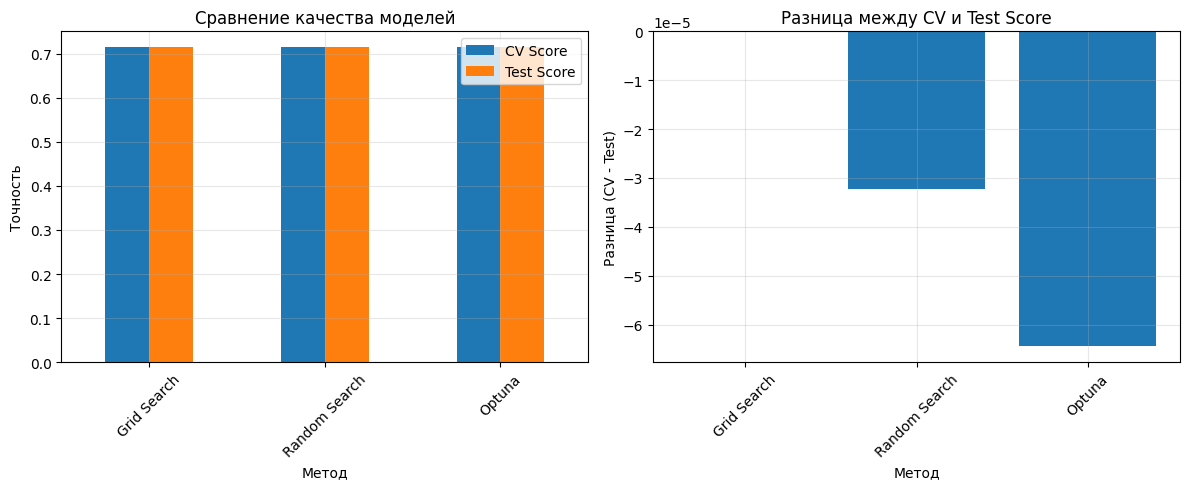

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

comparison_df[['CV Score', 'Test Score']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Сравнение качества моделей')
axes[0].set_xlabel('Метод')
axes[0].set_ylabel('Точность')
axes[0].set_xticklabels(comparison_df['Method'], rotation=45)
axes[0].legend(['CV Score', 'Test Score'])
axes[0].grid(True, alpha=0.3)

difference = comparison_df['CV Score'] - comparison_df['Test Score']
axes[1].bar(comparison_df['Method'], difference)
axes[1].set_title('Разница между CV и Test Score')
axes[1].set_xlabel('Метод')
axes[1].set_ylabel('Разница (CV - Test)')
axes[1].set_xticklabels(comparison_df['Method'], rotation=45)
axes[1].grid(True, alpha=0.3)
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    axes[0].text(i - 0.2, row['CV Score'] + 0.001, f"{row['CV Score']:.4f}", 
                ha='center', va='bottom', fontsize=9)
    axes[0].text(i + 0.2, row['Test Score'] + 0.001, f"{row['Test Score']:.4f}", 
                ha='center', va='bottom', fontsize=9)
    diff = row['CV Score'] - row['Test Score']
    axes[1].text(i, diff + (0.00001 if diff >= 0 else -0.00003), 
                f"{diff:.5f}", ha='center', va='bottom' if diff >= 0 else 'top', fontsize=9)
plt.tight_layout()
plt.show()

## 4. Интерпретация модели

### 4.1 Локальная интерпретация с LIME

!pip install lime


Пример 0: Реальный класс - Не популярный
Предсказание модели: Не популярный (вероятность популярного: 0.283)
Intercept 0.28459913510794166
Prediction_local [0.28332968]
Right: 0.2826391258936274


c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


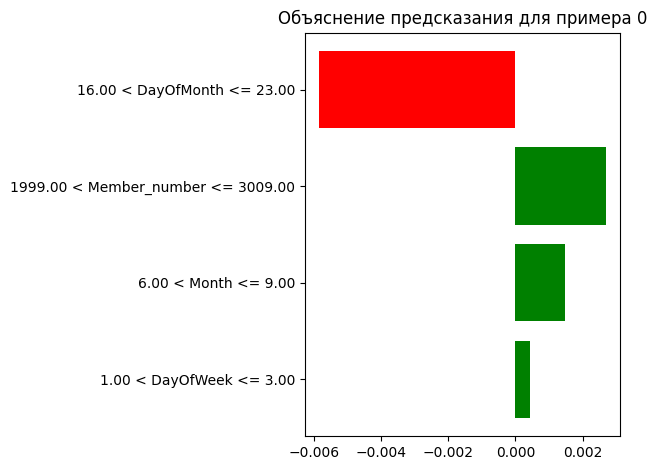


Пример 10: Реальный класс - Не популярный
Предсказание модели: Не популярный (вероятность популярного: 0.289)
Intercept 0.2854283799793387
Prediction_local [0.283412]
Right: 0.28947487497337865


c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


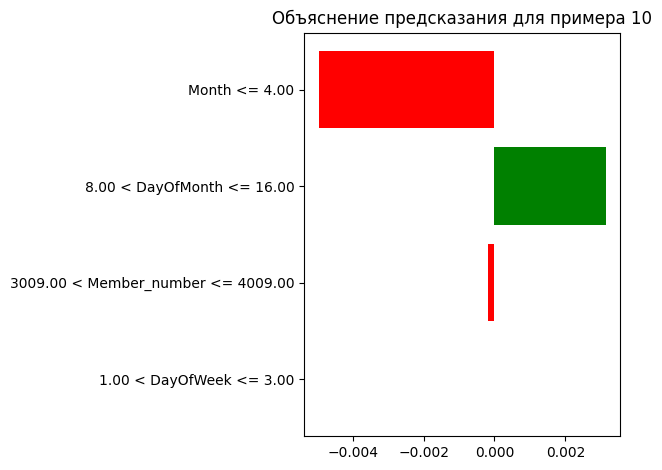


Пример 50: Реальный класс - Популярный
Предсказание модели: Не популярный (вероятность популярного: 0.280)
Intercept 0.2860307737303245
Prediction_local [0.27978744]
Right: 0.2798663819038557


c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


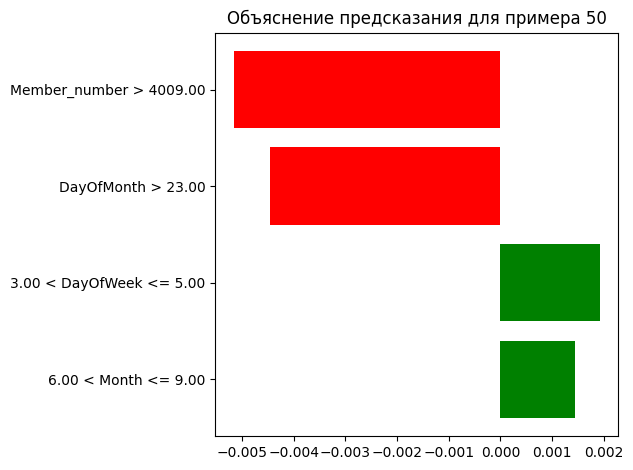


Пример 100: Реальный класс - Популярный
Предсказание модели: Не популярный (вероятность популярного: 0.291)
Intercept 0.2816928277918232
Prediction_local [0.2924282]
Right: 0.2905861766322121


c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


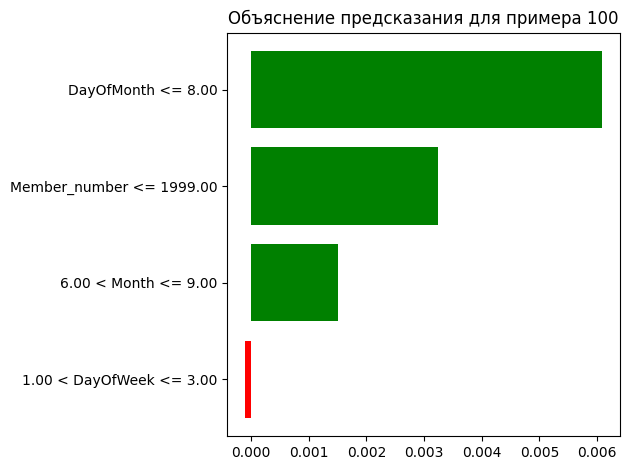

In [ ]:
import lime
import lime.lime_tabular

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(**study.best_params, random_state=42))
])
best_pipeline.fit(X_train, y_train)
feature_names = features
class_names = ['Не популярный', 'Популярный']

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    verbose=True,
    mode='classification'
)

sample_indices = [0, 10, 50, 100]
for idx in sample_indices:
    if idx < len(X_test):
        print(f"Пример {idx}: Реальный класс - {class_names[y_test.iloc[idx]]}")
        pred = best_pipeline.predict_proba(X_test.iloc[idx:idx+1])
        print(f"Предсказание модели: {class_names[np.argmax(pred)]} "
              f"(вероятность популярного: {pred[0][1]:.3f})")
        
        exp = explainer.explain_instance(
            X_test.iloc[idx].values,
            best_pipeline.predict_proba,
            num_features=len(feature_names)
        )
        exp.as_list()
        fig = exp.as_pyplot_figure()
        plt.title(f'Объяснение предсказания для примера {idx}')
        plt.tight_layout()
        plt.show()

### 4.2 Глобальная интерпретация с SHAP

!pip install shap

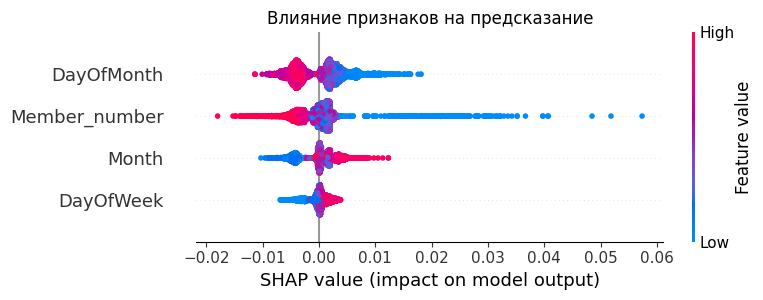

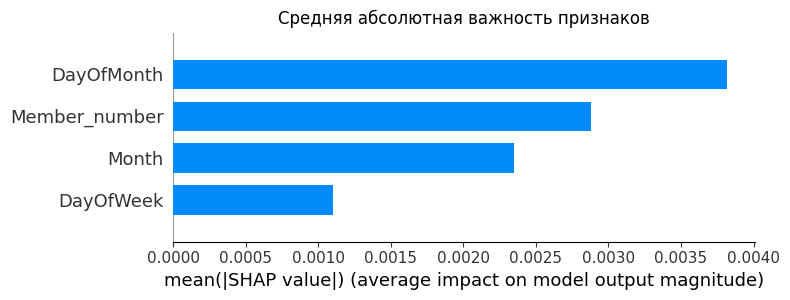

In [ ]:
import shap

model_for_shap = best_pipeline.named_steps['classifier']

scaler = best_pipeline.named_steps['scaler']
X_test_scaled = scaler.transform(X_test)

explainer_shap = shap.TreeExplainer(model_for_shap)

shap_values = explainer_shap.shap_values(X_test_scaled)

if len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 1]

shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.title('Влияние признаков на предсказание')
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar", show=False)
plt.title('Средняя абсолютная важность признаков')
plt.tight_layout()
plt.show()

## Выводы

In [ ]:
print("ИТОГОВЫЕ ВЫВОДЫ:")
print("\nСравнение методов подбора гиперпараметров:")
print(comparison_df.to_string())
best_method = comparison_df.loc[comparison_df['Test Score'].idxmax(), 'Method']
print(f"\nЛучший метод: {best_method}")
print(f"   Точность на тесте: {comparison_df.loc[comparison_df['Test Score'].idxmax(), 'Test Score']:.4f}")
print("\nСамые важные признаки:")
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
for feature, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True):
    print(f"   {feature}: {importance:.4f}")

ИТОГОВЫЕ ВЫВОДЫ:

Сравнение методов подбора гиперпараметров:
          Method  CV Score  Test Score
0    Grid Search  0.714562    0.714562
1  Random Search  0.714530    0.714562
2         Optuna  0.714498    0.714562

Лучший метод: Grid Search
   Точность на тесте: 0.7146

Самые важные признаки:
   Member_number: 0.4740
   DayOfMonth: 0.2602
   Month: 0.1635
   DayOfWeek: 0.1022
